#  Forecasting Stock Prices

## Objective:

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. In this notebook we provide a broad routine to make some AR, MA, ARMA and ARIMA models, in order to forecast the stock closing price of Amazon.

### Importing libraries

In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Pre-processing and Data Wrangling

In [2]:
# Read the data ser
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


The data set, contains only two variables, date (time) and close (stock price), with 144 observations, fortunately we don't have any missing values.

In [4]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


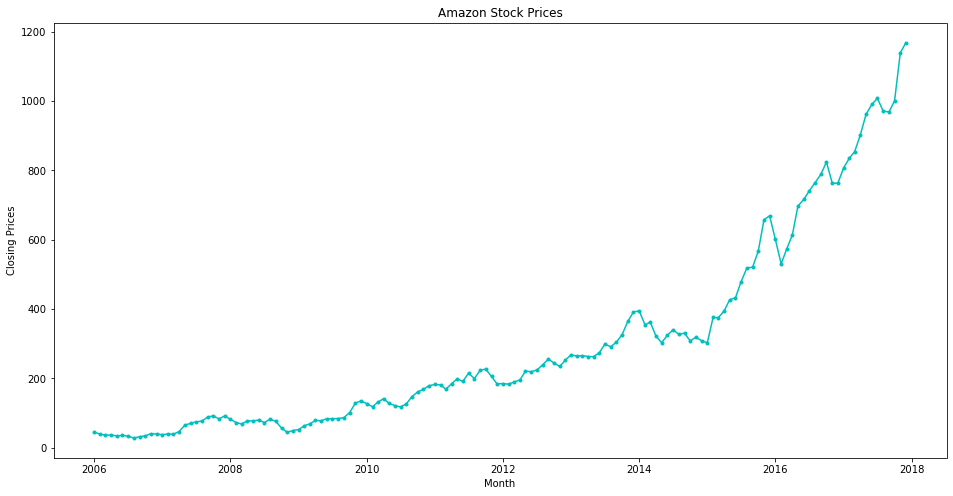

In [5]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

In [6]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


### Testing the stationarity of the series

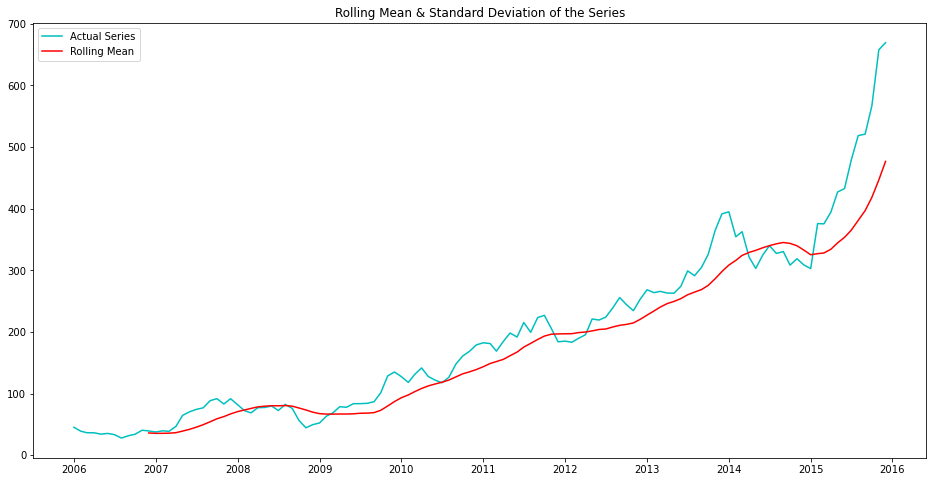

In [7]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [8]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

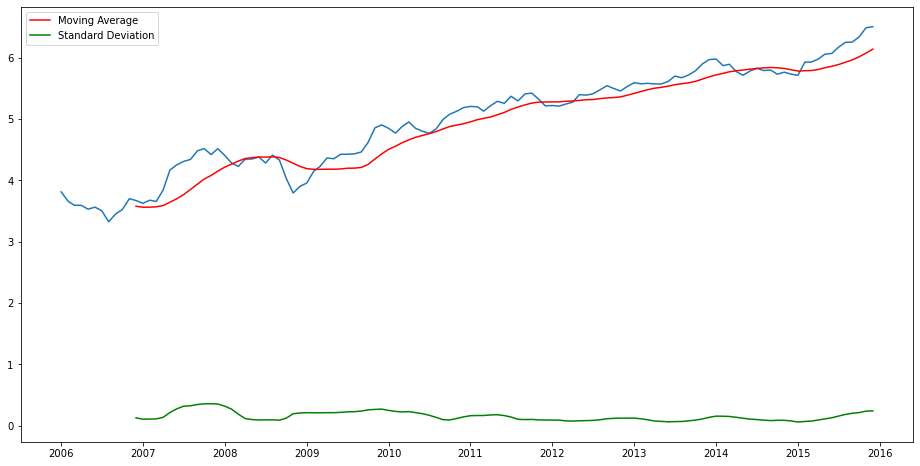

In [9]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

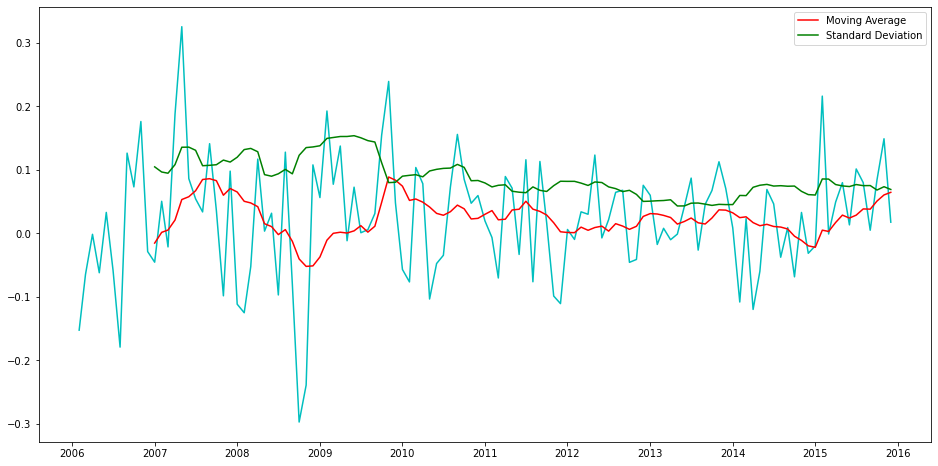

In [10]:
#Viusalize the rolling mean and the standard deviation of the shifted series 

plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:** 

- The mean and the standard deviation seem to be constant over time. Let us use the adfuller test to check the stationarity

In [11]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


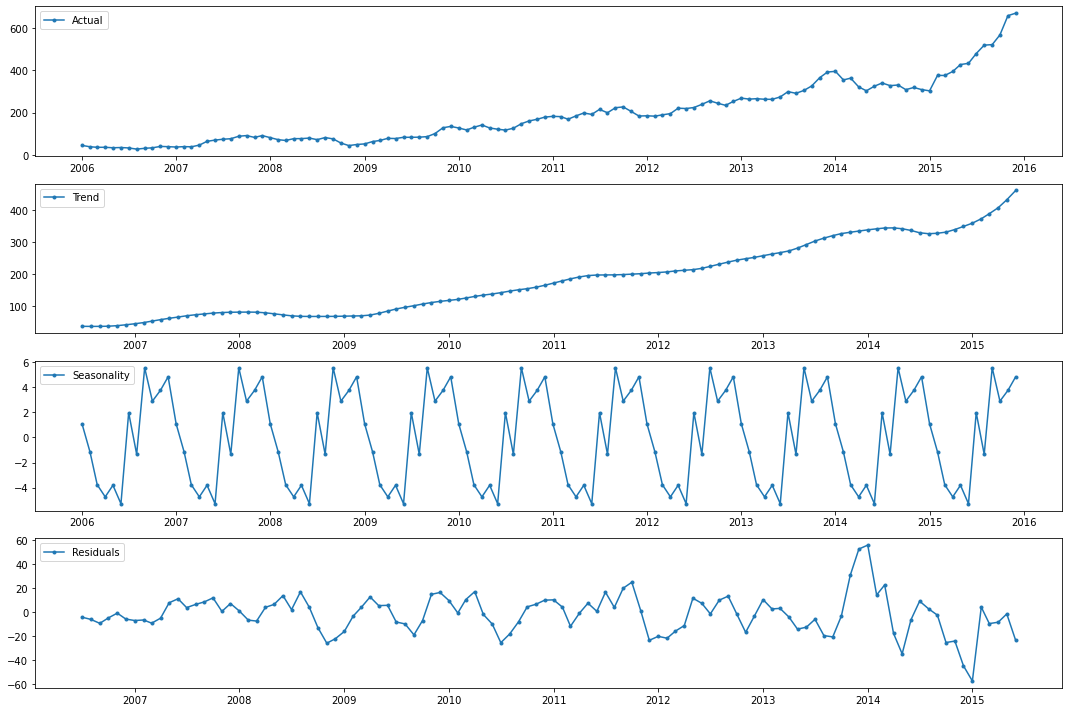

In [12]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant trend, seasonality and residuals components in the series
- The plot for seasonality shows that Amazon's stock prices spike in July, September, and December.

First, we will plot the ACF and PACF plots to get the values of p and q i.e. order of AR and MA models to be used.

<Figure size 1152x576 with 0 Axes>

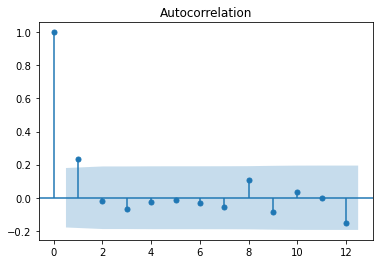

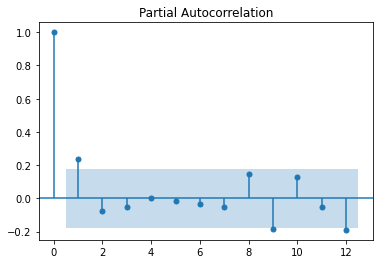

In [13]:
# Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that the highest lag at which the plot extends beyond the statistically significant boundary is lag 1. 
- This indicates that an AR Model of lag 1 (p=1) should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that q=1.

### AR Model

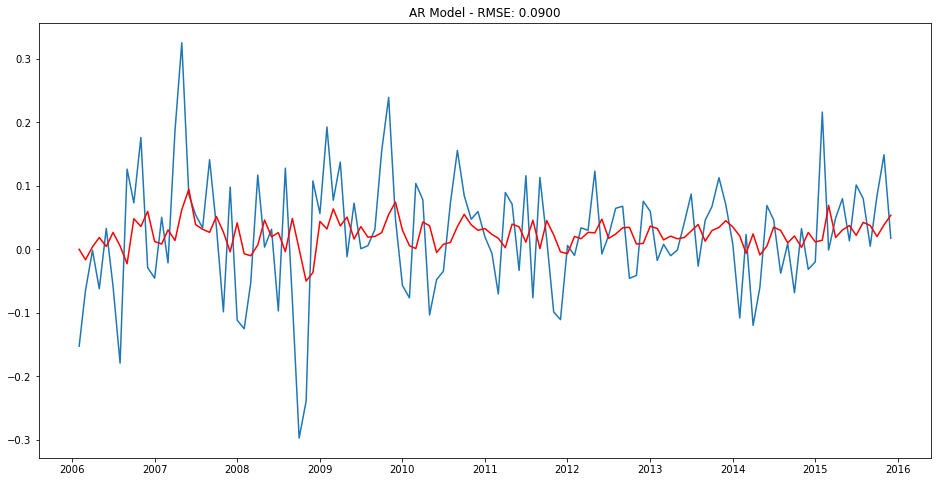

In [14]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags = 1) 
results_AR = model_AR.fit()
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1)
predict = predict.fillna(0) 
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  
plt.show()

**Observations:**

We can see that the prediction line (red) tends to minimize the spikes, of the series, and flattens it. Also we observe that the root mean standard error is small, let’s see how this compares to other models further ahead

In [15]:
results_AR.aic

-4.781419615400342

### MA Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87787D-01    |proj g|=  8.18311D-03

At iterate    5    f= -9.87794D-01    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   4.441D-08  -9.878D-01
  F = -0.98779386264513125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


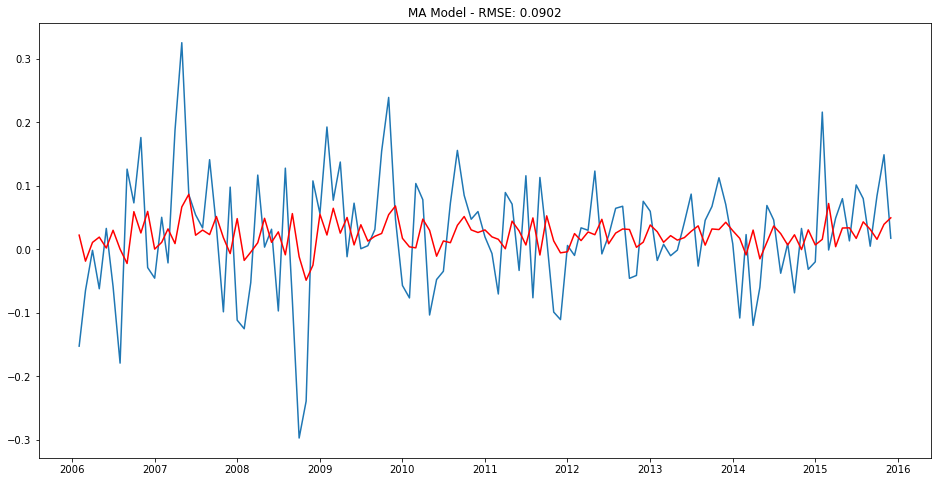

In [18]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order = (0,0,1))
results_MA = model_MA.fit()
plt.plot(df_shift)
predict = results_MA.predict()
predict = predict.fillna(0)
plt.plot(predict, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**

Compared to the AR model, the MA model, practically stays the same, the RMSE, improves marginally, from .0903, goes to .0902

In [19]:
results_MA.aic

-229.09493930954125

### ARMA Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87787D-01    |proj g|=  8.18311D-03

At iterate    5    f= -9.87794D-01    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   4.441D-08  -9.878D-01
  F = -0.98779386264513125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


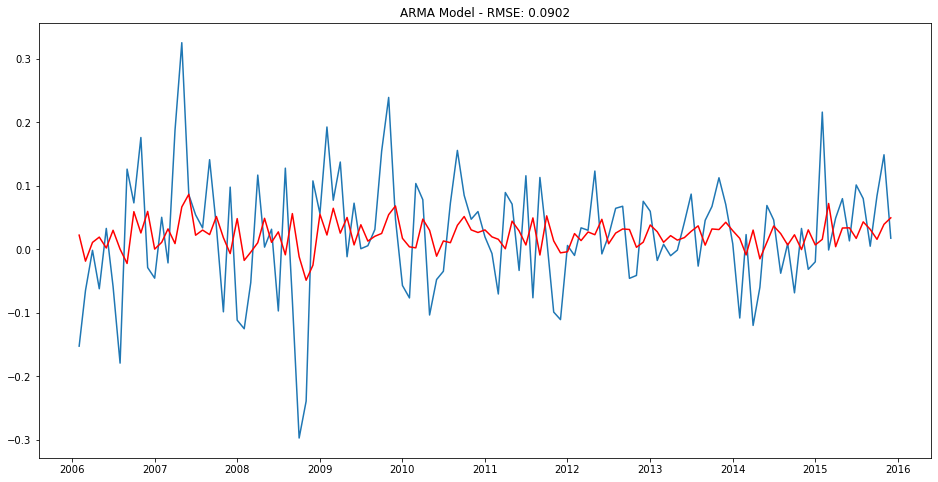

In [22]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order =(1,0,1)) 
results_ARMA = model_MA.fit()
plt.plot(df_shift)
predict = results_ARMA.predict()
predict = predict.fillna(0)
plt.plot(predict, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
The ARMA model is practically identical to de MA model.

In [23]:
results_ARMA.aic

-229.09493930954125

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87012D-01    |proj g|=  1.55890D-01

At iterate    5    f= -9.87252D-01    |proj g|=  5.57887D-03

At iterate   10    f= -9.87385D-01    |proj g|=  1.15506D-01

At iterate   15    f= -9.87863D-01    |proj g|=  1.33416D-04

At iterate   20    f= -9.87863D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   0.000D+00  -9.879D-01
  F = -0.98786257298149804     

CONVERG

 This problem is unconstrained.


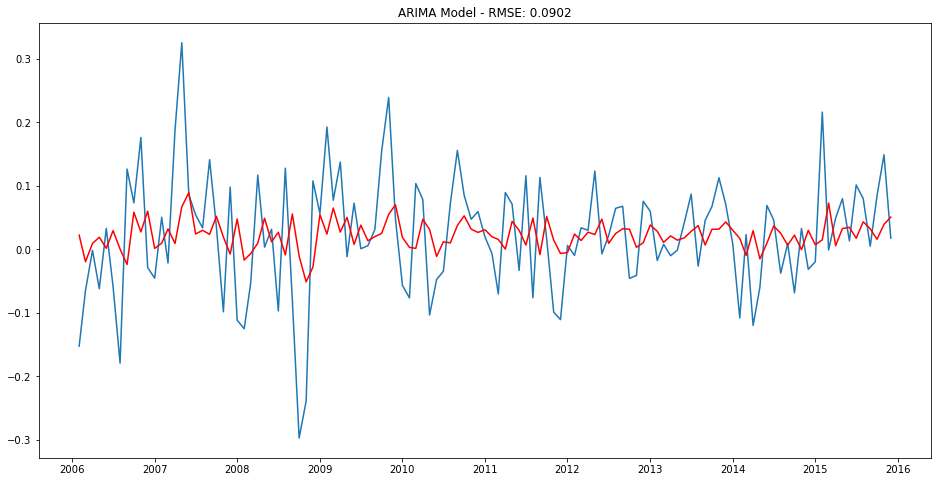

In [24]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order =(1,1,1)) 
results_ARIMA = model_ARIMA.fit()
plt.plot(df_shift)
predict = results_ARIMA.predict()
predict.fillna(0)
plt.plot(predict, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**

The ARIMA models does not vary significantly from the others, we can conclude that the RMSE, does not improve from one model to another.

In [25]:
results_ARIMA.aic

-227.11129236959653

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [26]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

In [27]:
#First step - doing cumulative sum
predictions_cumsum = predictions_cumsum = np.cumsum(np.cumsum(results_ARIMA.predict()))
predictions_cumsum

2006-02-01      0.022235
2006-03-01      0.024803
2006-04-01      0.036556
2006-05-01      0.067294
2006-06-01      0.099647
                 ...    
2015-08-01    144.230079
2015-09-01    146.788464
2015-10-01    149.362544
2015-11-01    151.975901
2015-12-01    154.639826
Freq: MS, Length: 119, dtype: float64

In [28]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

2006-01-01      3.811539
2006-02-01      3.833774
2006-03-01      3.836343
2006-04-01      3.848096
2006-05-01      3.878833
                 ...    
2015-08-01    148.041619
2015-09-01    150.600003
2015-10-01    153.174084
2015-11-01    155.787441
2015-12-01    158.451365
Length: 120, dtype: float64

In [29]:
#Third step - applying exponential transformation
predictions_ARIMA = np.cumsum(np.cumsum(results_ARIMA.predict()))
predictions_ARIMA

2006-02-01      0.022235
2006-03-01      0.024803
2006-04-01      0.036556
2006-05-01      0.067294
2006-06-01      0.099647
                 ...    
2015-08-01    144.230079
2015-09-01    146.788464
2015-10-01    149.362544
2015-11-01    151.975901
2015-12-01    154.639826
Freq: MS, Length: 119, dtype: float64

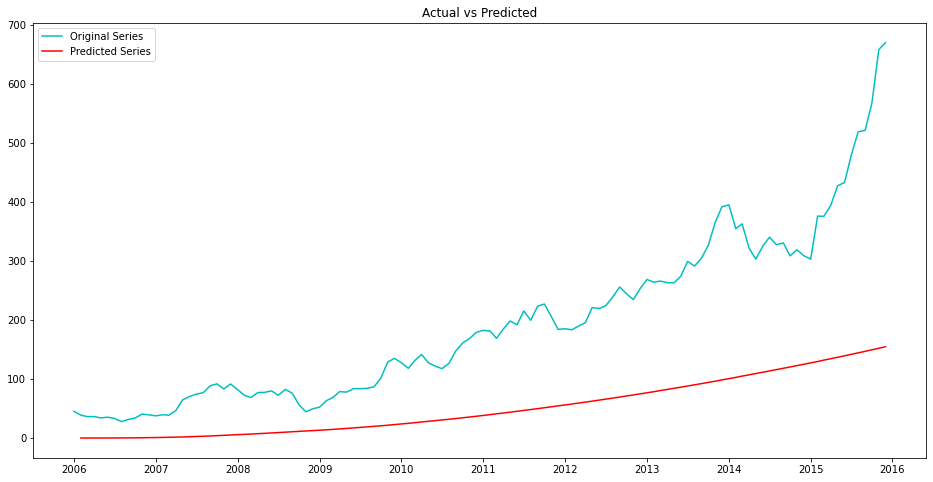

In [31]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

In [35]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.forecast(steps=24) 
forecasted_ARIMA[0]

array([6.52115936, 6.54310817, 6.56533178, 6.58756625, 6.60980114,
       6.63203605, 6.65427096, 6.67650587, 6.69874079, 6.7209757 ,
       6.74321061, 6.76544552, 6.78768043, 6.80991534, 6.83215025,
       6.85438516, 6.87662007, 6.89885498, 6.9210899 , 6.94332481,
       6.96555972, 6.98779463, 7.01002954, 7.03226445])

In [36]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     6.521159
1     6.543108
2     6.565332
3     6.587566
4     6.609801
5     6.632036
6     6.654271
7     6.676506
8     6.698741
9     6.720976
10    6.743211
11    6.765446
12    6.787680
13    6.809915
14    6.832150
15    6.854385
16    6.876620
17    6.898855
18    6.921090
19    6.943325
20    6.965560
21    6.987795
22    7.010030
23    7.032264
dtype: float64

In [37]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2016-01-01,6.521159
2016-02-01,6.543108
2016-03-01,6.565332
2016-04-01,6.587566
2016-05-01,6.609801
2016-06-01,6.632036
2016-07-01,6.654271
2016-08-01,6.676506
2016-09-01,6.698741
2016-10-01,6.720976


In [38]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = np.exp(df1['forecasted']) 
forecasted_ARIMA

2016-01-01     679.365560
2016-02-01     694.441667
2016-03-01     710.047439
2016-04-01     726.011786
2016-05-01     742.335385
2016-06-01     759.026015
2016-07-01     776.091918
2016-08-01     793.541529
2016-09-01     811.383476
2016-10-01     829.626581
2016-11-01     848.279862
2016-12-01     867.352544
2017-01-01     886.854054
2017-02-01     906.794035
2017-03-01     927.182346
2017-04-01     948.029067
2017-05-01     969.344504
2017-06-01     991.139196
2017-07-01    1013.423919
2017-08-01    1036.209691
2017-09-01    1059.507777
2017-10-01    1083.329696
2017-11-01    1107.687225
2017-12-01    1132.592408
Name: forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

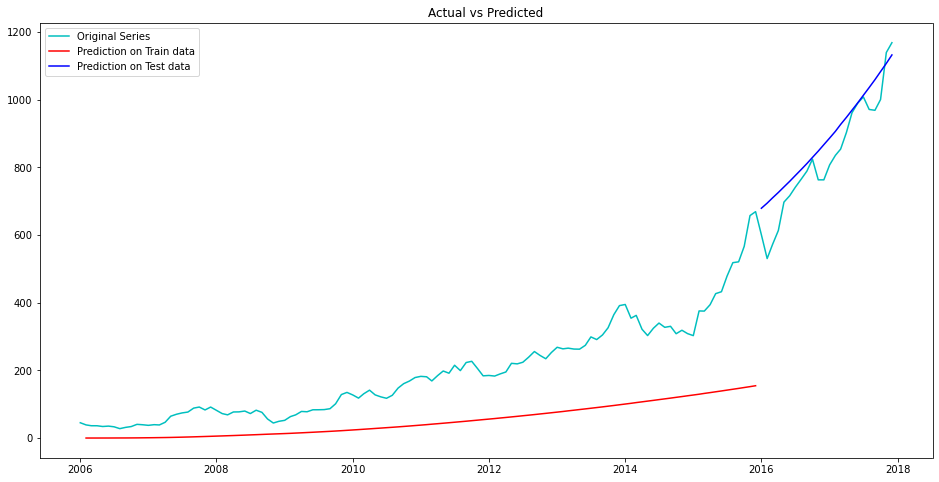

In [39]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. 

In [43]:
#calculate RMSE using the predictions_ARIMA and df_train 
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_ARIMA, df_test, squared = False)
error

73.39354251031654

In [50]:
df_train.shape
df2 = df_train.drop(df_train.index[0])
print(df2.shape)

(119, 1)


In [53]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(predictions_ARIMA, df2, squared = False) 
error

171.70534366567978